<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221102_porto_driver_bayesian_opt_OOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1)

In [4]:
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [5]:
from sklearn.preprocessing import OneHotEncoder

# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature] 

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성
# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) 

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

#### 파생 피처 추가

In [6]:
# 첫번째 : 결측값 개수를 파생피처로

# '피처별 결측값 개수'를 파생피처로 추가
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [7]:
# 명목형 피처, calc 분류의 피처를 제외한 피처명만 남길것
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and 'calc' not in feature)]

# num_missing을 remaining_features 리스트에 추가
remaining_features.append('num_missing')

remaining_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'num_missing']

In [8]:
len([feature for feature in all_features if 'ind' in feature])

18

In [9]:
# 두번째 : 모든 ind 피처 값을 연결해 새로운 피처를 만들자(총 18개의 ind 피처)
# 피처명 : ps_ind_01 + ps_ind_03 + ... ps_ind_18_bin= mix_ind
# 연결된값 : 2_2_5_..._4

# 분류가 ind인 피처
ind_features = [feature for feature in all_features if 'ind' in feature]


# 반복문을 사용할때 첫번째만 다른 조건을 사용하고 싶은 경우

## 반복문 내 사용될 조건문의 Bool 초기화 설정
is_first_feature = True

for ind_feature in ind_features:
    # 반복문 내 첫번째만 적용할 조건
    if is_first_feature:
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_' # dtype이 str인 Series에 문자열을 더하는경우 자동으로 브로드캐스팅
        # 첫번째만 적용이후 조건 변경
        is_first_feature = False
    else:
        all_data['mix_ind'] += all_data[ind_feature].astype(str) + '_' # dtype이 str인 Series에 문자열을 더하는경우 자동으로 브로드캐스팅
    

#### Series.astype(str)과 Series.str 비교

 - Series.astype(str) : 단순히 dtype만 변경

  > String타입인 Series에 문자열을 추가하는 것은 자동으로 브로드캐스팅 적용 됨

 - Series.str.함수() : dtype이 String인 Series에 각 element에 여러가지 함수(ex. count(), len(), startswith()등)를 적용하여 Series를 return

#### Series와 List의 += 개념 차이
 - Series.astype(str) += '1' : 각 element의 우측에 '1'이 붙음
  
  > Int타입인 Series에 1이 더해지면 이때는 리스트와 마찬가지로 각 element에 1이 더해지는 브로드캐스팅이 적용 됨

 - ['1','2,'3'] += '1' : 리스트 마지막 element로 '1'이 들어옴

  > [1, 2, 3] += 1 : 각element에 1이 더해지는 브로드캐스팅 적용 됨

#### DataFrame['new feature'] += Series
 - 새로운 피처를 정의할때 초기화 하지않으면 연산을 할 수 없다
 - 현재 존재하지 않는 피처인 경우 += 연산을 바로 사용 할 수 없다

In [10]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [11]:
# 세번째 : 명목형 피처의 고유값별 개수를 새로운 피처로 추가 : value_counts()
## 해당 고유값이 많은 고유값일 수록 숫자가 크다 → 중요한 의미 → 모델링시 가중치를 갖는다

all_data['ps_ind_02_cat'].unique() # 고유값 종류
all_data['ps_ind_02_cat'].nunique() # 고유값 개수(종류수)

all_data['ps_ind_02_cat'].value_counts() # 고유값 종류 별 개수를 Series로(index:종류, value:개수)


 1    1079327
 2     309747
 3      70172
 4      28259
-1        523
Name: ps_ind_02_cat, dtype: int64

In [12]:
# Series를 Dict로 : to_dict()
all_data['ps_ind_02_cat'].value_counts().to_dict()

{1: 1079327, 2: 309747, 3: 70172, 4: 28259, -1: 523}

In [13]:
cat_count_features = []
for feature in cat_features+['mix_ind']: # mix_ind피처도 명목형 피처
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: val_counts_dict[x])
    # all_data[f'{feature}_count'] = all_data[feature].map(val_counts_dict)
    cat_count_features.append(f'{feature}_count')

#### map vs apply 간단비교
 - Series.map(dict)

 - DataFrame/Series.apply(lambda x: dict[x]) 가능

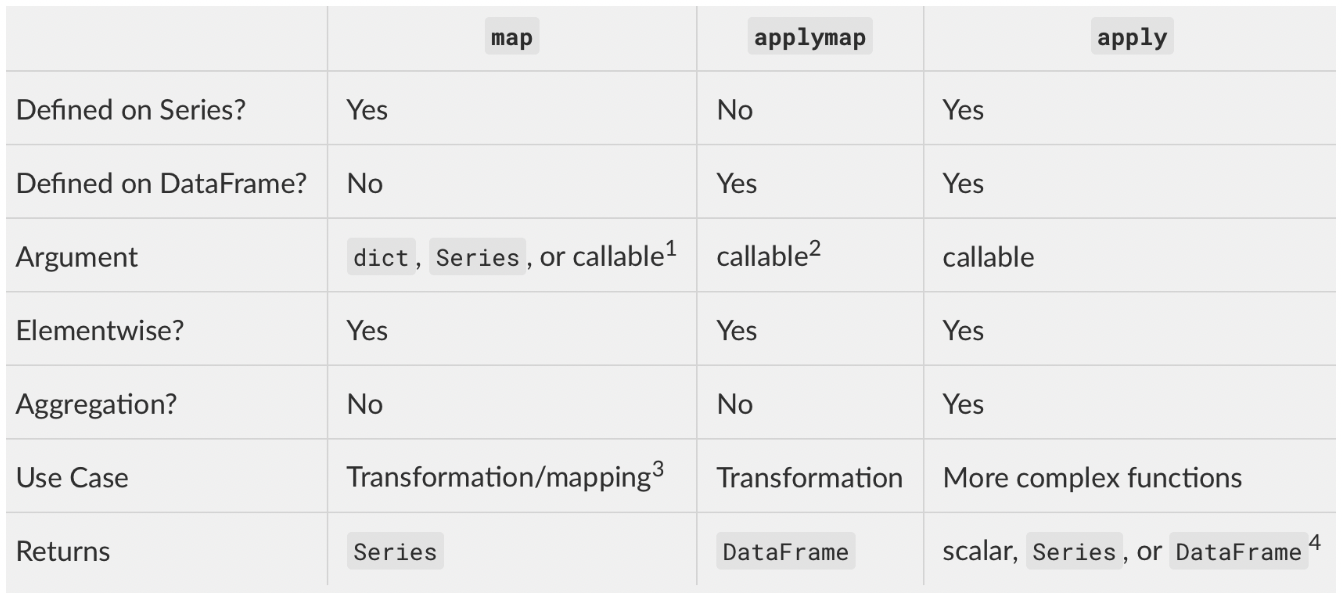

In [14]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

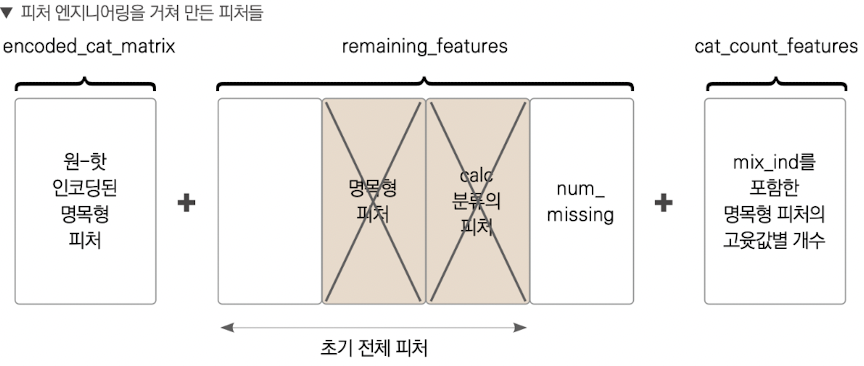

In [15]:
# 필요 없는 피처 제거 → 피처엔지니어링된 모든 피처 합치기

from scipy import sparse

# 필요 없는 피처들
drop_features = ['ps_ind_14', 'ps_ind_10_bin','ps_ind_11_bin',
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14']

# remaining_features, cat_count_features에서 drop_features를 제거한 데이터
all_data_remaining = all_data[remaining_features+cat_count_features].drop(drop_features, axis=1)

# 데이터 합치기 : CSR타입과 DataFrame타입
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining), # DataFrame 
                               encoded_cat_matrix], # CSR
                              format='csr')

#### 데이터 나누기

In [16]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

In [17]:
# 정규화 지니계수 계산 함수 정의

import numpy as np

# '실제값'과 '예측값'을 입력받아 정규화된 지니계수 반환하는 함수
def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape # 가정설정문 assert 사용법 : assert 조건, '메시지'(생략가능)
    
    n_samples = y_true.shape[0] # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # np.linspace(0, 1, N) : 0에서 1사이값으로 N개 데이터 배열

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred.argsort() : y_pred의 오름차순 인덱스
    # 로렌츠 곡선
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # cumsum([1,2,3]) : [1,3,6] 각 원소의 누적 합
    # 예측값에 대한 지니계수
    G_pred = np.sum(L_mid - L_pred)

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true크기 순으로 y_true값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true) # 예측이 완벽할 때 지니계수

    # 정규화 된 지니계수
    return G_pred / G_true

In [18]:
# LightGBM모델 훈련시 검증 파라미터에 전달할 "자체제작 gini() 함수"
def gini(preds, dtrain):
    labels = dtrain.get_label() # dtrain.get_label() : dtrain의 타깃값을 반환
    return 'gini', eval_gini(labels, preds), True # 반환값 3가지 필요 : '평가지표이름', '평가 점수 반환하는 함수', '평가 점수가 높을수록 좋은지 여부'

### 하이퍼파라미터 최적화 : 베이지안 최적화 기법 사용
 - 그리드서치 대비 빠르고, 효율적, 직관적

#### 데이터셋 준비

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 8:2 비율 훈련데이터, 검증데이터 분리(베이지안 최적화 수행용)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# 베이지안 최적화용 데이터 셋(LightGBM전용 데이터 셋 사용 : 훈련 및 검증용으로만(예측X))
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

#### 하이퍼파라미터 범위 설정

In [20]:
# 베이지안 최적화 기법으로 찾아나갈 하이퍼파라미터 범위
param_bounds = {'num_leaves':(30, 40),
                'lambda_l1':(0.7, 0.9),
                'lambda_l2':(0.9, 1),
                'feature_fraction':(0.6, 0.7),
                'bagging_fraction':(0.6, 0.9),
                'min_child_samples':(6, 10),
                'min_child_weight':(10, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective':'binary',       # 이진분류 문제
                'learning_rate':0.005,
                'bagging_freq':1,
                'force_row_wise':True,      # 경고문구 삭제
                'random_state':1991}        # 반복실행에도 동일결과를 위해

# 최고성능(평가지표(지니계수) 계산 함수 사용)을 낸 하이퍼파라미터를 찾는것이 베이지안 최적화의 목표

#### (베이지안 최적화용) 평가지표 계산 함수 작성
 


```
# 베이지안 최적화
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수명을 파라미터로
                                 pbounds=param_bounds) # eval_function 함수의 파라미터에 param_bounds 하이퍼 파라미터 범위를 던져주게 됨 

# 베이지안 최적화 수행
optimizer.maximize(init_points=3,   # 무작위로 하이퍼파라미터를 탐색하는 횟수
                   niter=6)         # 베이지안 최적화 반복횟수
# 모델 훈련을 총 9번 반복하게 됨   
```

```
# (베이지안 최적화용)평가지표 계산 함수
def eval_function(탐색할 하이퍼 파라미터 딕셔너리 키):    # 위의 베이지안 최적화 수행시 pbounds 파라미터를 통해 받은 params_bounds 범위안에서 해당 평가지표 계산함수가 반복해서 돌게됨
    params = {'탐색할 하이퍼 파라미터 키' : 키,
                ...
                '고정된 하이퍼 파라미터 키' : 키
                }

    # LightGBM 모델 훈련(베이지안 최적화의 평가지표 계산 함수 내에서 훈련하게 됨)
    lgb_model = lgb.train(params=params,
                        train_set=bayes_dtrain,
                        valid_sets=bayes_dvalid,
                        ...
                        feval=gini)   # 검증용 평가지표 (자체제작)함수이름 : 3가지 값을 return해야함 → '평가지표이름', '평가점수를 return하는 함수', 값이 클수록 좋은지 True/False
    
    ...

    return gini_score     # 지니계수 값
```





In [21]:
# (베이지안 최적화용)평가지표 계산 함수 

def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):    # 베이지안 최적화 수행시 pbounds 파라미터를 통해 받은 params_bounds 범위안에서 해당 평가지표 계산함수가 반복해서 돌게됨                  
    
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'num_leaves' : int(round(num_leaves)),  # 베이지안 최적화 수행시 pbounds파라미터를 통해 하이퍼파라미터 범위를 제공 받음 
              'lambda_l1' : lambda_l1,
              'lambda_l2' : lambda_l2,
              'feature_fraction' : feature_fraction,
              'bagging_fraction' : bagging_fraction,
              'min_child_samples': int(round(min_child_samples)), # 베이지안 최적화를 수행하면 하이퍼파라미터 지정 범위 내 실숫값을 탐색하게됨 → 정수형으로 변경
              'min_child_weight' : min_child_weight,
              'feature_pre_filter': False}

    # 고정된 하이퍼파라미터도 추가(하지만 최적화를 수행하지는 못함)
    params.update(fixed_params)

    print('하이퍼파라미터:', params)

    # LightGBM 모델 훈련(베이지안 최적화의 평가지표 계산 함수 내에서 훈련하게 됨)
    lgb_model = lgb.train(params=params,
                          train_set=bayes_dtrain,
                          valid_sets=bayes_dvalid,
                          feval=gini,                # 검증용 평가지표 (자체제작)함수이름 : 3가지 값을 return해야함 → '평가지표이름', '평가점수를 return하는 함수', 값이 클수록 좋은지 True/False
                          early_stopping_rounds=300, # 검증용 평가지표인 gini함수의 return값인 eval_gini함수의 값(지니계수)으로 조기종료 여부 판단
                          verbose_eval=False)
    
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid)
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)  # eval_gini() : 정규화된 지니계수를 계산하는 '자체제작' 함수
    print(f'지니계수: {gini_score}\n')

    return gini_score     # 지니계수 값

In [22]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,       # 베이지안 최적화용 평가지표 계산 함수
                                 pbounds=param_bounds,  # 베이지안 최적화용 평가지표 계산 함수의 파라미터에 전달해줄 하이퍼파라미터 범위(딕셔너리)
                                 random_state=0)

In [ ]:
%%time
# 베이지안 최적화 수행
optimizer.maximize(init_points=3,  # 무작위로 하이퍼파라미터를 탐색하는 횟수
                   n_iter=6)         # 베이지안 최적화 반복횟수
# 모델훈련 총 9번 반복

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
지니계수: 0.25327234010386845

| 1         | 0.2533    | 0.7646    | 0.6715    | 0.8206    | 0.9545    | 7.695     | 29.38     | 34.38     |
하이퍼파라미터: {'num_leaves': 39, 'lambda_l1': 0.7766883037651555, 'lambda_l2': 0.9791725038082665, 'feature_fraction': 0.6963662760501029, 'bagging_fraction': 0.867531900234624, 'min_child_samples': 8, 'min_child_weight': 27.04133683281797, 'feature_pre_filter': False,

#### 결과 확인
 - 지니계수가 최대가 되는 하이퍼파라미터 = 최적 하이퍼파라미터

 - 참고사항 : 그리드서치와 달리 베이지안 최적화는 최적 예측기(최적 하이퍼파라미터 값들로 훈련된 모델) 제공하지 않음

 > 6.베이지안 최적화 객체를 생성할 때 2가지 파라미터 : 1) 베이지안 최적화 계산함수명(eval_function), 2) 최적화할 하이퍼파라미터 객체(param_bounds)

 > 5.param_bounds 하이퍼파라미터 범위를 여러차례/다양하게 eval_function의 파라미터로 넣는다.

 > 4.eval_function의 파라미터에 따라 모델 훈련 수행

 > 3.모델 훈련은 feval파라미터로 받은 gini함수에 따라 최적의 모델이 되도록 훈련한다
  - 최적의 모델이 되도록한 하이퍼파라미터를 뽑는다.
  - 베이지안 최적화를 통한 9번을 모델 훈련 중 가장 높은값을 저장한다 : optimizer.max['params']

 > 2.gini함수는 eval_gini함수를 return
 
 > 1.eval_gini는 정규화된 지니계수 값을 return 

In [ ]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params'] # 베이지안 최적화 객체에 값이 저장되어 있음
max_params

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 0.7,
 'lambda_l2': 0.9809590379511716,
 'min_child_samples': 9.346204139493736,
 'min_child_weight': 39.455117883167624,
 'num_leaves': 40.0}

 - num_leaves, min_child_samples는 원래 정수형 하이퍼파라미터이므로 정수형으로 변환하여 다시저장

In [ ]:
# 정수형 하이퍼파라미터 변환
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [ ]:
# 값이 고정된 하이퍼파라미터도 추가
max_params.update(fixed_params)

In [25]:
max_params = {'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 0.7,
 'lambda_l2': 0.9809590379511716,
 'min_child_samples': 9,
 'min_child_weight': 39.455117883167624,
 'num_leaves': 40,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}
max_params

{'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'lambda_l1': 0.7,
 'lambda_l2': 0.9809590379511716,
 'min_child_samples': 9,
 'min_child_weight': 39.455117883167624,
 'num_leaves': 40,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

 - 최적의 하이퍼파라미터를 찾았음
 - 단순히, 최적의 하이퍼파라미터로 훈련을 하는것이 아니라
 - OOF 방식으로 모델 훈련 및 예측하는 이유는?

  > 하이퍼파라미터를 수정하는것이 아니라

  > 1.층화 K폴드 교차 검증기를 통해 테스트 데이터 예측값을 더욱 정밀하게 예측

  > 2.층화 K폴드 교차 검증기를 통해 훈련된 모델의 성능을 확인(하는 방법)

### 모델 훈련 및 성능 검증
 - 그리드 서치와 달리 베이지안 최적화는 최적 예측기(최적 하이퍼파라미터값들로 훈련된 모델) 제공하지 않음
 - 따라서, 베이지안 최적화로 찾은 하이퍼파라미터를 활용해 LightGBM다시 훈련

In [28]:
%%time
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기 생성
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)

# OOF 방식으로 훈련된 모델로 "검증 데이터의 타깃값을 예측한 확률"을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0])
# OOF 방식으로 훈련된 모델로 "테스트 데이터의 타깃값을 예측한 확률"을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)): # # StratifiedKFold().split(X, y) : generator타입, 훈련,검증데이터셋의 인덱스 반환 
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드{idx+1} / 폴드 {folds.n_splits}', '#'*40)

    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM전용 검증 데이터셋

    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params, # bayesian_opt로 얻은 최적 하이퍼파라미터
                          train_set=dtrain,
                          valid_sets=dvalid,
                          num_boost_round=2500,
                          feval=gini,                   # 검증용 평가지표 (자체제작)함수이름 : 3가지 값을 return해야함 → '평가지표이름', '평가점수를 return하는 함수', 값이 클수록 좋은지 True/False
                          early_stopping_rounds=300,    # 검증용 평가지표인 gini함수의 return값인 eval_gini함수의 값(지니계수)으로 조기종료 여부 판단
                          verbose_eval=100)             # 100번째 마다 점수 출력
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측(예측용 데이터는 lgb.Dataset이 아닌 원본사용)
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid) # 최초 0인 초기화된 리스트에 검증데이터를 넣어서 나온 예측값으로 채움
    # oof_val_preds 최초 : [0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...] : 훈련데이터 크기와 같음(0으로 채워짐)
    # oof_val_preds 1차  : [예측값,..][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...] 
    # oof_val_preds 2차  : [예측값,..][예측값,..][0,0,0,...][0,0,0,...][0,0,0,...] 
    
    # 테스트 데이터를 활용해 OOF 예측(예측용 데이터는 lgb.Dataset이 아닌 원본사용)
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # oof_test_preds 최초 : [0,0,0,...] : 테스트데이터 크기와 같음
    # oof_test_preds 1차  : [예측값1,.] / 5
    # oof_test_preds 2차  : [예측값1,.] / 5 + [예측값2,.] / 5

    # 각 폴드별 모델 훈련을 위해 사용되는 지니계수와 별개로 각 폴드별 최종 지니계수 확인용 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    # y_valid 1차        : [실제값,..][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...]
    # oof_val_preds 1차  : [예측값,..][0,0,0,...][0,0,0,...][0,0,0,...][0,0,0,...] 
    # gini_score 값 1차  : [위의 두값] 폴드 1 지니계수

    # y_valid 2차        : [실제값,..][실제값,..][0,0,0,...][0,0,0,...][0,0,0,...]
    # oof_val_preds 2차  : [예측값,..][예측값,..][0,0,0,...][0,0,0,...][0,0,0,...] 
    # gini_score 값 2차  :            [위의 두값] 폴드 2 지니계수

    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n') 
    # 모델의 훈련상태를 모니터링 하기 위한 지니계수일뿐
    # 모델의 성능을 평가하는것은 전체 훈련데이터의 실제값과 oof_val_preds로 해야함
    # y             : [실제값,..][실제값,..][실제값,..][실제값,..][실제값,..]
    # oof_val_preds : [예측값,..][예측값,..][예측값,..][예측값,..][예측값,..]
    

######################################## 폴드1 / 폴드 5 ########################################
Training until validation scores don't improve for 300 rounds.
[100]	valid_0's binary_logloss: 0.154245	valid_0's gini: 0.271687
[200]	valid_0's binary_logloss: 0.153175	valid_0's gini: 0.275994
[300]	valid_0's binary_logloss: 0.15257	valid_0's gini: 0.280289
[400]	valid_0's binary_logloss: 0.1522	valid_0's gini: 0.284061
[500]	valid_0's binary_logloss: 0.151963	valid_0's gini: 0.287157
[600]	valid_0's binary_logloss: 0.151795	valid_0's gini: 0.289888
[700]	valid_0's binary_logloss: 0.151681	valid_0's gini: 0.291829
[800]	valid_0's binary_logloss: 0.151589	valid_0's gini: 0.293637
[900]	valid_0's binary_logloss: 0.151515	valid_0's gini: 0.295269
[1000]	valid_0's binary_logloss: 0.151468	valid_0's gini: 0.296421
[1100]	valid_0's binary_logloss: 0.151436	valid_0's gini: 0.297083
[1200]	valid_0's binary_logloss: 0.151405	valid_0's gini: 0.29778
[1300]	valid_0's binary_logloss: 0.151386	valid_0's g

 - 모델의 성능평가 점수가 2개

  > valid_0's binary_logloss: 이진분류할때, LightGBM의 기본평가(default)지표

  > valid_0's gini: 모델훈련할때, feval파라미터에 전달한 gini함수의 계산 값


 - 사실상 모델의 성능을 평가하는것은 각 폴드별 지니계수가 아님
 
  > 폴드별 지니계수는 훈련중 훈련상태를 확인하기 위함(지니계수가 상승하며 훈련이 잘되고 있는지)

  > 최종 훈련데이터로 예측한 y_oof_val_preds와 훈련데이터의 실제값으로 모델 성능 평가

In [ ]:
# 각폴드별 지니계수 확인 하는것과 달리 oof_val_preds가 예측값으로 다찬상태에서 실제값과의 gini_score 
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds)) # y_valid가 반복문으로 폴드 5차까지 다돌면 y임
# y             : [실제값,..][실제값,..][실제값,..][실제값,..][실제값,..]
# oof_val_preds : [예측값,..][예측값,..][예측값,..][예측값,..][예측값,..]

# 이것이 모델의 성능을 평가하는 지표이며, 이값으로 다른하이퍼파라미터 또는 lgb가아닌 xgb등과 모델을 비교